# Publication Analytics

Contains publication analytics such as publication per year, publication rate of change, top published journals, frequently used words, and abstract distribution.

## ✋Set Up

### Set up GPUs

In [ ]:
# GPU information:

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In order to use a GPU with your notebook, select the **Runtime > Change runtime** type menu, and then set the hardware accelerator dropdown to GPU.

### High RAM

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available.

You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via **Runtime > Change runtime** type in the menu. Then select High-RAM in the Runtime shape dropdown. After, re-execute the code cell.

### Install libraries

In [ ]:
#installing for this work.
!pip install --quiet  numpy==1.25.2 pandas==1.5.3 plotly==5.15.0 psutil==5.9.5 scikit-learn==1.2.2 WordCloud==1.9.3 kaleido==0.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.


In [ ]:
import torch
import sklearn
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

import kaleido
import re  # Regular expression library

import warnings
warnings.filterwarnings;

## 📊Plots

In [ ]:
df = pd.read_hdf('Files/embeddings_full_tSNE_uMAP_01MAR2024.h5', key='embeddings')

In [ ]:
df.head();

### Publication Per Year

In [ ]:
# Calculate the number of publications per year
publications_per_year = df['pub_year'].value_counts().sort_index()

# Convert the Series to a DataFrame for plotting
publications_per_year_df = publications_per_year.reset_index()
publications_per_year_df.columns = ['Year', 'Number of Publications']

# Create a bar plot
fig = px.bar(publications_per_year_df, x='Year', y='Number of Publications',
             #title='Number of Publications Per Year'
             )

# Add black outlines to the bars
fig.update_traces(marker=dict(line=dict(color='black', width=1.5)))

# Update the layout
fig.update_layout(
    plot_bgcolor='white',
    height=550, width=400, #600 by 800
    title_font=dict(size=24, family='Optima, sans-serif'),
    font=dict(size=18, family='Optima, sans-serif'),
    xaxis_title_font=dict(size=25, family='Optima, sans-serif', color='black'),
    yaxis_title_font=dict(size=25, family='Optima, sans-serif', color='black'),
    xaxis_tickfont=dict(size=20),
    yaxis_tickfont=dict(size=20)
)

# Show the figure
fig.show()

In [ ]:
# Save the figure to a file
#pio.write_image(fig, '/content/gdrive/My Drive/code/Metabolomics Landscape/Figures/publications_per_year.png')  # Saves as PNG
#pio.write_image(fig, '/content/gdrive/My Drive/code/Metabolomics Landscape/Figures/publications_per_year.pdf')  # Saves as PDF
pio.write_image(fig, '/content/gdrive/My Drive/code/Metabolomics Landscape/Figures/publications_per_year.svg')  # Saves as SVG

### Publication Per Year: Rates of Change

#### Derivatives Computations

In [ ]:
# Calculate the number of publications per year
publications_per_year = df['pub_year'].value_counts().sort_index()

# Convert the Series to a DataFrame for plotting
publications_per_year_df = publications_per_year.reset_index()
publications_per_year_df.columns = ['Year', 'Number of Publications']

In [ ]:
publications_per_year_df.head()

,Year,Number of Publications
0,1998.0,1
1,1999.0,1
2,2000.0,7
3,2001.0,12
4,2002.0,40


In [ ]:
# Save the DataFrame to an Excel file
#publications_per_year_df.to_excel('/content/gdrive/My Drive/current/Metabolomics Landscape/publications_per_year.xlsx', index=False)

In [ ]:
# Define a function to compute the derivative of the number of publications per year
def compute_derivative(year1, year2, df):
    if year1 == year2:
        return 0.0

    if year1 > year2:
        year1, year2 = year2, year1

    index1 = int(year1 - 1998)
    index2 = int(year2 - 1998)

    num_publications_year1 = df.iloc[index1, df.columns.get_loc('Number of Publications')]
    num_publications_year2 = df.iloc[index2, df.columns.get_loc('Number of Publications')]

    derivative = (num_publications_year2 - num_publications_year1) / (year2 - year1)
    return derivative

In [ ]:
# Filter out the year 2024
filtered_df = publications_per_year_df[publications_per_year_df['Year'] != 2024]

1.  **Highest and Lowest Rate of Change:**

In [ ]:
# Create a new dataframe to store derivatives
derivative_df = pd.DataFrame(columns=['Year1', 'Year2', 'Derivative'])

# Iterate over each year and calculate derivatives
for year1 in filtered_df['Year']:
    for year2 in filtered_df['Year'][filtered_df['Year'] > year1]:
        derivative = compute_derivative(year1, year2, filtered_df)
        # Create a temporary DataFrame for the new row
        new_row = pd.DataFrame({'Year1': [year1], 'Year2': [year2], 'Derivative': [derivative]})
        # Concatenate the new row with the existing DataFrame
        derivative_df = pd.concat([derivative_df, new_row], ignore_index=True)

# Sort by derivative to find highest and lowest
lowest_derivatives = derivative_df.sort_values('Derivative').head(5)
highest_derivatives = derivative_df.sort_values('Derivative', ascending=False).head(5)

In [ ]:
print("Lowest Derivatives (excluding 2024):\n",
      lowest_derivatives.to_markdown(index=False, numalign="left", stralign="left"))
print("\nHighest Derivatives (excluding 2024):\n",
      highest_derivatives.to_markdown(index=False, numalign="left", stralign="left"))

Lowest Derivatives (excluding 2024):
 | Year1   | Year2   | Derivative   |
|:--------|:--------|:-------------|
| 1998    | 1999    | 0            |
| 1998    | 2000    | 3            |
| 1998    | 2001    | 3.66667      |
| 2000    | 2001    | 5            |
| 1999    | 2001    | 5.5          |

Highest Derivatives (excluding 2024):
 | Year1   | Year2   | Derivative   |
|:--------|:--------|:-------------|
| 2020    | 2021    | 1872         |
| 2019    | 2021    | 1653.5       |
| 2020    | 2022    | 1559.5       |
| 2018    | 2021    | 1549.33      |
| 2019    | 2022    | 1518         |



After excluding the 2024 data point, the analysis reveals the following insights about the dataset of metabolomics papers published each year:


-   The highest rate of change occurred between 2020 and 2021, with an average increase of 1872 publications per year.
-   The lowest rate of change was between 1998 and 1999, with no change in the number of publications.






2.  **Mean Rate of Change:**
    -   The average rate of change across all pairs of years is 447.58, indicating an overall increasing trend in publications.

In [ ]:
# Calculate and print the mean derivative
mean_derivative = derivative_df['Derivative'].mean()
print(f"\nThe mean derivative across all year pairs (excluding 2024) is: {mean_derivative:.2f}")


The mean derivative across all year pairs (excluding 2024) is: 447.58


3.  **Consistently High and Low Rates of Change:**

The consistently high and low rates of change were determined by comparing the mean derivative for each starting year (`Year1`) to the overall mean derivative across all year pairs. The standard deviation of the derivatives for each `Year1` was also considered to account for the variability in the rates of change.

Here's a breakdown of the steps involved in the calculation:

a. **Calculate Mean and Standard Deviation:** The code first groups the `derivative_df` by `Year1` and calculates the mean and standard deviation of the `Derivative` for each group. This gives us an idea of the average rate of change and its variability for each starting year.

b. **Set Thresholds:** Two thresholds are then established:
   - **High Threshold:** Overall mean derivative + standard deviation for each `Year1`.
   - **Low Threshold:** Overall mean derivative - standard deviation for each `Year1`.

c. **Filter Years:**
   - **High Rate Years:** Years where the mean derivative for that `Year1` is above the high threshold are considered to have consistently high rates of change.
   - **Low Rate Years:** Years where the mean derivative for that `Year1` is below the low threshold are considered to have consistently low rates of change.

This approach allows us to identify years that consistently exhibit rates of change significantly above or below the average, taking into account the variability in the data.

In [ ]:
# Group by Year1 and calculate mean and std of derivatives
grouped_by_year1 = derivative_df.groupby('Year1')['Derivative'].agg(['mean', 'std'])

# Filter for years with consistently high or low rate of change
threshold = mean_derivative + grouped_by_year1['std']
high_rate_years = grouped_by_year1[grouped_by_year1['mean'] > threshold]

threshold = mean_derivative - grouped_by_year1['std']
low_rate_years = grouped_by_year1[grouped_by_year1['mean'] < threshold]

In [ ]:
print("\nYears with consistently high rate of change (excluding 2024):")
print(high_rate_years.to_markdown(numalign="left", stralign="left"))

print("\nYears with consistently low rate of change (excluding 2024):")
print(low_rate_years.to_markdown(numalign="left", stralign="left"))


Years with consistently high rate of change (excluding 2024):
| Year1   | mean    | std     |
|:--------|:--------|:--------|
| 2011    | 627.571 | 179.101 |
| 2013    | 766.467 | 176.619 |
| 2014    | 796.214 | 214.889 |
| 2015    | 924.815 | 186.246 |
| 2016    | 942.881 | 264.335 |
| 2017    | 1151.25 | 217.462 |
| 2018    | 1412.38 | 98.4056 |
| 2019    | 1477.12 | 147.447 |
| 2020    | 1563.06 | 307.182 |
| 2021    | 1098.75 | 209.657 |

Years with consistently low rate of change (excluding 2024):
| Year1   | mean    | std     |
|:--------|:--------|:--------|
| 1998    | 159.944 | 155.85  |
| 1999    | 176.804 | 161.287 |
| 2000    | 195.678 | 166.849 |
| 2001    | 218.961 | 170.63  |
| 2002    | 242.702 | 175.831 |


    
-   Years 2011, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, and 2021 show consistently high rates of change, suggesting a period of accelerated growth in publications.
-   Years 1998, 1999, 2000, 2001, and 2002 exhibit consistently low rates of change, indicating a relatively slower initial growth phase.

**In summary it appears that the early years have consistently low rates of change, while the later year have consistently high rates of change.**

These findings provide a quantitative basis for understanding the evolution of metabolomics publications over time, while excluding potentially incomplete data from 2024.

#### Plot Derivatives

In [ ]:
import plotly.express as px
import pandas as pd

# Define years and calculate derivatives, explicitly including 2022 and 2023
years = range(1998, 2024)  # Include 2023
derivatives_y = []
for i in range(len(years) - 1):
    year1 = years[i]
    year2 = years[i + 1]
    derivatives_y.append(compute_derivative(year1, year2, filtered_df))

# Create a DataFrame for derivatives
derivatives_df = pd.DataFrame({'Year': years[:-1], 'Rate of Change': derivatives_y})

# Merge derivatives_df with filtered_df
merged_df = pd.merge(filtered_df, derivatives_df, on='Year', how='left')

# Create a bar plot for Number of Publications
fig = px.bar(merged_df, x='Year', y='Number of Publications',
             color_discrete_sequence=['blue'], opacity=0.6,
             labels={'Number of Publications': 'Number of Publications'},
             title='Number of Publications and Rate of Change Per Year')

# Add black outlines to the bars
fig.update_traces(marker=dict(line=dict(color='black', width=1.5)))

# Add a line plot for Rate of Change on the secondary y-axis
fig.add_scatter(x=merged_df['Year'], y=merged_df['Rate of Change'], mode='lines+markers',
                line=dict(color='orange'), marker=dict(color='orange', size=8),
                name='Rate of Change', yaxis='y2')  # Assign to secondary y-axis

# Update the layout
fig.update_layout(
    plot_bgcolor='white',
    height=550, width=650,
    title_font=dict(size=24, family='Optima, sans-serif'),
    font=dict(size=18, family='Optima, sans-serif'),
    xaxis_title_font=dict(size=20, family='Optima, sans-serif', color='black'),
    yaxis_title_font=dict(size=20, family='Optima, sans-serif', color='black'),
    xaxis_tickfont=dict(size=16),
    yaxis_tickfont=dict(size=16),
    legend=dict(font=dict(size=18)),
    yaxis2=dict(title='Rate of Change', overlaying='y', side='right', range=[0, 2000])
)

# Show the figure
fig.show()

In [ ]:
# Save the figure to a file
pio.write_image(fig, '/content/gdrive/My Drive/current/Metabolomics Landscape/Figures/pubs_rate_of_change.png')  # Saves as PNG
#pio.write_image(fig, '/content/gdrive/My Drive/current/Metabolomics Landscape/Figures/pubs_rate_of_change.pdf')  # Saves as PDF

### Top 10 Most Published Journals

In [ ]:
# Calculate the top 10 most published journals
top_journals = df['journal_title'].value_counts().head(10)

# Create a horizontal bar chart with Plotly Express
fig = px.bar(
    x=top_journals.values,  # Frequency count on the x-axis
    y=top_journals.index,   # Journal titles on the y-axis
    labels={'x': 'Frequency', 'y': 'Journal Title'},  # Adjust labels
    color_discrete_sequence=['#656ef2'] * len(top_journals),  # Apply the color to all bars
    template='plotly_white'  # Use a clean background template for aesthetic appeal
)

# Add black outlines to the bars
fig.update_traces(marker=dict(line=dict(color='black', width=1.5)))

# Update the layout with x-axis at the top
fig.update_layout(
    plot_bgcolor='white',
    height=500, width=1200,  # Adjust height and width
    title_font=dict(size=24, family='Avenir Next, sans-serif'),
    font=dict(size=18, family='Avenir Next, sans-serif'),
    xaxis_title_font=dict(size=25, family='Avenir Next, sans-serif', color='black'),
    yaxis_title_font=dict(size=25, family='Avenir Next, sans-serif', color='black'),
    xaxis_tickfont=dict(size=20),
    yaxis_tickfont=dict(size=20),
    xaxis=dict(side='top'),  # Move x-axis to the top
    yaxis=dict(autorange="reversed")  # Reverse the order of y-axis to flip the journal list
)

# Show the figure
fig.show()

### Top 10 Most Published Authors

In [ ]:
# Split the 'authors' column by ',', explode to separate rows, and count occurrences
top_authors = df['authors'].str.split(',').explode().value_counts().head(10)

# Create a bar chart with Plotly Express
fig = px.bar(
    x=top_authors.index,
    y=top_authors.values,
    labels={'x': 'Author', 'y': 'Publications Count'},
    title='Top 10 Most Published Authors',
    color_discrete_sequence=['RoyalBlue'] * len(top_authors),  # Apply an attractive color to all bars
    template='plotly_white'  # Use a clean background template for aesthetic appeal
)

# Customize the layout with specific figure dimensions
fig.update_layout(
    xaxis_title='Author',
    yaxis_title='Publications Count',
    width=800,  # Adjust the width of the figure
    height=600   # Adjust the height of the figure
)

# Show the plot
fig.show()

### Frequently Used 100 Words

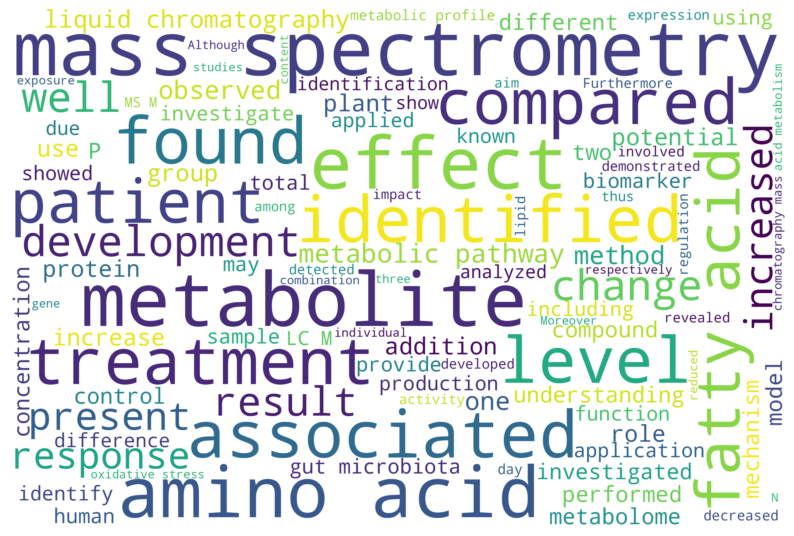

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd  # Assuming you have imported pandas as well

# Start with default stopwords from WordCloud
default_stopwords = set(STOPWORDS)

# Define your custom stopwords
custom_stopwords = {'used', 'study'}

# Combine the default stopwords with your custom stopwords
combined_stopwords = default_stopwords.union(custom_stopwords)

# Increase the resolution of the word cloud
high_res_width = 3000
high_res_height = 2000

# Generate the word cloud
wc = WordCloud(background_color="white",
               max_words=100,
               width=high_res_width, height=high_res_height,
               stopwords=combined_stopwords)

wordcloud = wc.generate(df['abstract'].str.cat(sep=" "))

# Plot the word cloud
plt.figure(figsize=(10, 14))  # You can adjust the size here
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Save the word cloud as a high-resolution SVG
#wordcloud_file_path = '/content/gdrive/My Drive/code/Metabolomics Landscape/Figures/frequent_words_v2.svg'
#plt.savefig(wordcloud_file_path, dpi=600, bbox_inches='tight')
plt.show()

### Abstract Distribition: Characters & Words

In [ ]:
df['num_characters'] = df['abstract'].apply(len)
df['num_words'] = df['abstract'].apply(lambda x: len(x.split()))

# Create subplots: 1 row, 2 columns
fig = make_subplots(rows=1, cols=2,
                    #subplot_titles=("Distribution of Abstract Characters",
                    #                "Distribution of Abstract Words")
                    )


# Histogram for the number of characters
fig.add_trace(
    go.Histogram(x=df['num_characters'], name='Characters'),
    row=1, col=1
)

# Histogram for the number of words
fig.add_trace(
    go.Histogram(x=df['num_words'], name='Words'),
    row=1, col=2
)

# Update layout
fig.update_layout(
    plot_bgcolor='white',
    height=600, width=800,
    title_font=dict(size=24, family='Optima, sans-serif'),
    font=dict(size=18, family='Optima, sans-serif'),
    bargap=0.2
)

# Update axis properties
fig.update_xaxes(
    title_text="Number of Characters", title_font=dict(size=20, family='Optima, sans-serif', color='black'),
    tickfont=dict(size=16), row=1, col=1
)
fig.update_xaxes(
    title_text="Number of Words", title_font=dict(size=20, family='Optima, sans-serif', color='black'),
    tickfont=dict(size=16), row=1, col=2
)
fig.update_yaxes(
    title_text="Number of Papers", title_font=dict(size=20, family='Optima, sans-serif', color='black'),
    tickfont=dict(size=16), row=1, col=1
)
fig.update_yaxes(
    title_text="Number of Papers", title_font=dict(size=20, family='Optima, sans-serif', color='black'),
    tickfont=dict(size=16), row=1, col=2
)

# Set x-axis limits
fig.update_xaxes(range=[0, 3500], row=1, col=1)
fig.update_xaxes(range=[0, 550], row=1, col=2)

# Show the figure
fig.show()

### Abstract Distribution: Words

In [ ]:
# Calculate the number of words in each abstract
df['num_words'] = df['abstract'].apply(lambda x: len(x.split()))

# Create a histogram for the number of words
fig = go.Figure()
fig.add_trace(go.Histogram(x=df['num_words'], name='Words'))

# Update layout
fig.update_layout(
    plot_bgcolor='white',
    height=550, width=400,
    #title='Distribution of Abstract Words',
    title_font=dict(size=24, family='Optima, sans-serif'),
    font=dict(size=18, family='Optima, sans-serif'),
    bargap=0.2
)

# Update axis properties
fig.update_xaxes(
    title_text="Number of Words", title_font=dict(size=20, family='Optima, sans-serif', color='black'),
    tickfont=dict(size=16)
)
fig.update_yaxes(
    title_text="Number of Papers", title_font=dict(size=20, family='Optima, sans-serif', color='black'),
    tickfont=dict(size=16)
)

# Set x-axis limits
fig.update_xaxes(range=[0, 550])

# Show the figure
fig.show()